### Calculate integrated APAR from satellite extraction and connect to ground data
Uses smoothed NDVI time series from LMF and HLS satellite data extracted at CPER plot scale.
Calculates fPAR, then APAR using NEON PAR readings. Calculated integrated APAR by summing 
APAR from the start of season (calculated separately from the NDVI time series) up until the 
date of clipping for production.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
# keep block and ecosite
# what happened to new heavy
# erika is sorting out 2022 biomass

#### Input/Output paths

In [3]:
ndvi_path =  "../data/training/iapar/cper_ndvi_plotscale_2014_2022_cln.csv" 
sos_path = "../data/training/iapar/cper_sos_2014_2022.csv"
par_path = "../data/sensors/par/neon_d10_cper_par_cln.csv"
ground_path = "../data/ground/clipping/AGM_Biomass_Widecln_attr_2023-07-18.csv"
dates_path = "../data/ground/clipping/CARM_Biomass_SamplingDates.csv"

In [4]:
outPATH = "../data/training/iapar/cper_biomass_iapar_2014_2022.csv"

#### Helper functions

In [5]:
def ndvi_to_fpar(ndvi_ts):
    SR = (1 + ndvi_ts) / (1 - ndvi_ts)
    # SR_min = 1.55  # this is based on Grigera et al., 2007
    SR_min = 1.11  # this is based on an NDVI of 0.05
    SR_max = 11.62
    fPAR = SR / (SR_max - SR_min) - SR_min / (SR_max - SR_min)
    return fPAR

def calc_apar_baseline(apar, sos):
    apar_baseline = np.median(apar.iloc[:sos])
    return apar_baseline

def remove_apar_sos(apar, sos):
    apar_mod = apar.copy()
    apar_mod.iloc[:sos] = np.nan
    return apar_mod

In [6]:
ndvi = pd.read_csv(ndvi_path, parse_dates=[0])
par = pd.read_csv(par_path, parse_dates=[0])
sos = pd.read_csv(sos_path, parse_dates=[3])
ground = pd.read_csv(ground_path)
s_dates = pd.read_csv(dates_path)

In [7]:
# calculate fPAR from NDVI
ndvi['fPAR'] = ndvi_to_fpar(ndvi['NDVI_smooth_avg'])

#convert SamplingDate column to datetime
s_dates['SamplingDate'] = pd.to_datetime(s_dates['SamplingDate'])

# manually fix incorrect date
s_dates[s_dates['SamplingDate'] == pd.to_datetime('2020-04-08')] = pd.to_datetime('2020-08-04')

# get year from date in PAR and sampling data
par['Year'] = par['Date'].dt.year
s_dates['Year'] = s_dates['SamplingDate'].dt.year

# rename pasture in ground data
ground.loc[ground['Pasture'] == 'NH', 'Pasture'] = '10S'
s_dates.loc[s_dates['Pasture'] == 'NH', 'Pasture'] = '10S'

# add block to new heavy so that it carries through
ground.loc[ground['Treatment'] == 'NEW_HVY', 'Block'] = 99

#create new column in ground that is a combination of Pasture and plot the format "Pasture_"P"Plot"
ground['Id'] = ground['Pasture'].astype(str) + '_' + "P"+ ground['Plot'].astype(str)
#add same column to sampling_dates
s_dates['Id'] = s_dates['Pasture'].astype(str) + '_' + "P"+ s_dates['Plot'].astype(str)
#add year column to sampling_dates

#drop Pasture, Plot, Transect, Distance columns from sampling_dates
s_dates = s_dates.drop(columns=['Transect', 'Distance', 'Plot', 'Pasture'])
# drop duplicates
s_dates = s_dates.drop_duplicates()

#### Biomass calculations

In [8]:
# COULD DROP PLOTS WITH HIGH SS

# List of biomass columns to be summed
biomass_cols = ['BOBU', 'WSPG', 'C3PG', 'FORB', 'AG']#, 'C4PG', 'VUOC']

# Calculate the sum of the biomass columns for each year and id
ground['Total_Biomass'] = ground[biomass_cols].sum(axis=1)
#rename 'YearSampled' to Year
ground = ground.rename(columns={"YearSampled": "Year"})

In [9]:
#rename StartDateTime column from par to Date and PAR_MJ_m2_day to PAR
par = par.rename(columns={"startDateTime": "Date", "PAR_MJ_m2_day": "PAR"})

# create new dataframe that is a subset of columns needed from ndvi dataframe
APAR = ndvi[['Date', 'Id', 'fPAR','NDVI_smooth_avg','Year']]

#take only date and PAR columns from PAR
par = par[['Date', 'PAR']]
APAR = pd.merge(APAR, par, on='Date')

#sort by Id, Date
APAR = APAR.sort_values(by=['Id', 'Date'])
#add APAR column, which is fPAR * PAR
APAR['APAR'] = APAR['fPAR'] * APAR['PAR']
#Add year column
APAR['Year'] = pd.DatetimeIndex(APAR['Date']).year

In [10]:
# check if any year is missing data in s_dates and populate with Aug. 4
for plot in ground['Id'].unique():
    for yr in range(2014, 2023):
        if yr not in s_dates[s_dates['Id'] == plot]['Year'].unique():
            new_data = pd.DataFrame({
                'Id': plot,
                'Year': yr,
                'SamplingDate': pd.to_datetime(str(yr) + '-08-04')
            }, index=[max(s_dates.index.values) + 1])
            # Append the new data to s_dates
            s_dates = pd.concat([s_dates, new_data], ignore_index=True)

In [13]:
#add median sampling date column
s_dates['Median_Sampling_Date'] = s_dates.groupby(['Id', 'Year'])['SamplingDate'].transform('median')

#drop SamplingDate column
s_dates = s_dates.drop(columns=['SamplingDate'])
#rename Median_Sampling_Date to SamplingDate
s_dates = s_dates.rename(columns={"Median_Sampling_Date": "SamplingDate"})

# convert back to datetime without time
s_dates['SamplingDate'] = s_dates['SamplingDate'].dt.normalize()

# drop newly duplicated values
s_dates = s_dates.drop_duplicates()

AttributeError: 'DataFrame' object has no attribute 'drop_duplicated'

In [16]:
# calculate baseline APAR based on SOS
APAR_baseline = APAR.groupby(['Year', 'Id']).apply(
    lambda x: calc_apar_baseline(x['APAR'], sos['SOS_doy'][(sos['Year'] == x.name[0]) &
                                        (sos['Id'] == x.name[1])].values[0]))
APAR_baseline.name = 'APAR_baseline'
APAR_baseline = APAR_baseline.reset_index()

In [17]:
APAR = pd.merge(APAR, APAR_baseline, on=['Id', 'Year'])

In [18]:
#Add new column that is APAR - Baseline_APAR
APAR['APAR_adjusted'] = APAR['APAR'] - APAR['APAR_baseline']
#convert adjusted APAR that are negative to 0

APAR['APAR_adjusted'] = np.where(APAR['APAR_adjusted'] < 0, 0, APAR['APAR_adjusted'])
#iAPAR calculation

# create a new column that has APAR values starting from SOS and NaNs before this date
APAR['APAR_modified'] = APAR.groupby(['Year', 'Id'])['APAR_adjusted'].transform(
    lambda x: remove_apar_sos(x, sos['SOS_doy'][(sos['Year'] == x.name[0]) &
                                        (sos['Id'] == x.name[1])].values[0]))

# calculate the cumulative sum per year and store it in the 'iAPAR' column
APAR['iAPAR'] = APAR.sort_values(['Id', 'Year', 'Date']).groupby(['Id', 'Year'])['APAR_modified'].cumsum()

In [19]:
ground_mean = ground.drop(columns=['Unnamed: 0', 
                     'Transect',
                     'PastureSize_ha',
                     'X', 'Y']).groupby(['Year', 'Pasture',
                                        'Plot', 'Id', 
                                        'Treatment', 'Block', 'Ecosite']).mean(numeric_only=True).reset_index()

ground_mean = pd.merge(ground_mean, s_dates, on=['Year', 'Id'], how='left')

In [20]:
# Select relevant columns from APAR
df_merged = pd.merge(ground_mean, APAR[['Id', 'Date', 'iAPAR']],
                     left_on=['Id', 'SamplingDate'],
                     right_on=['Id', 'Date'],
                     how='left').drop(columns=['SamplingDate'])

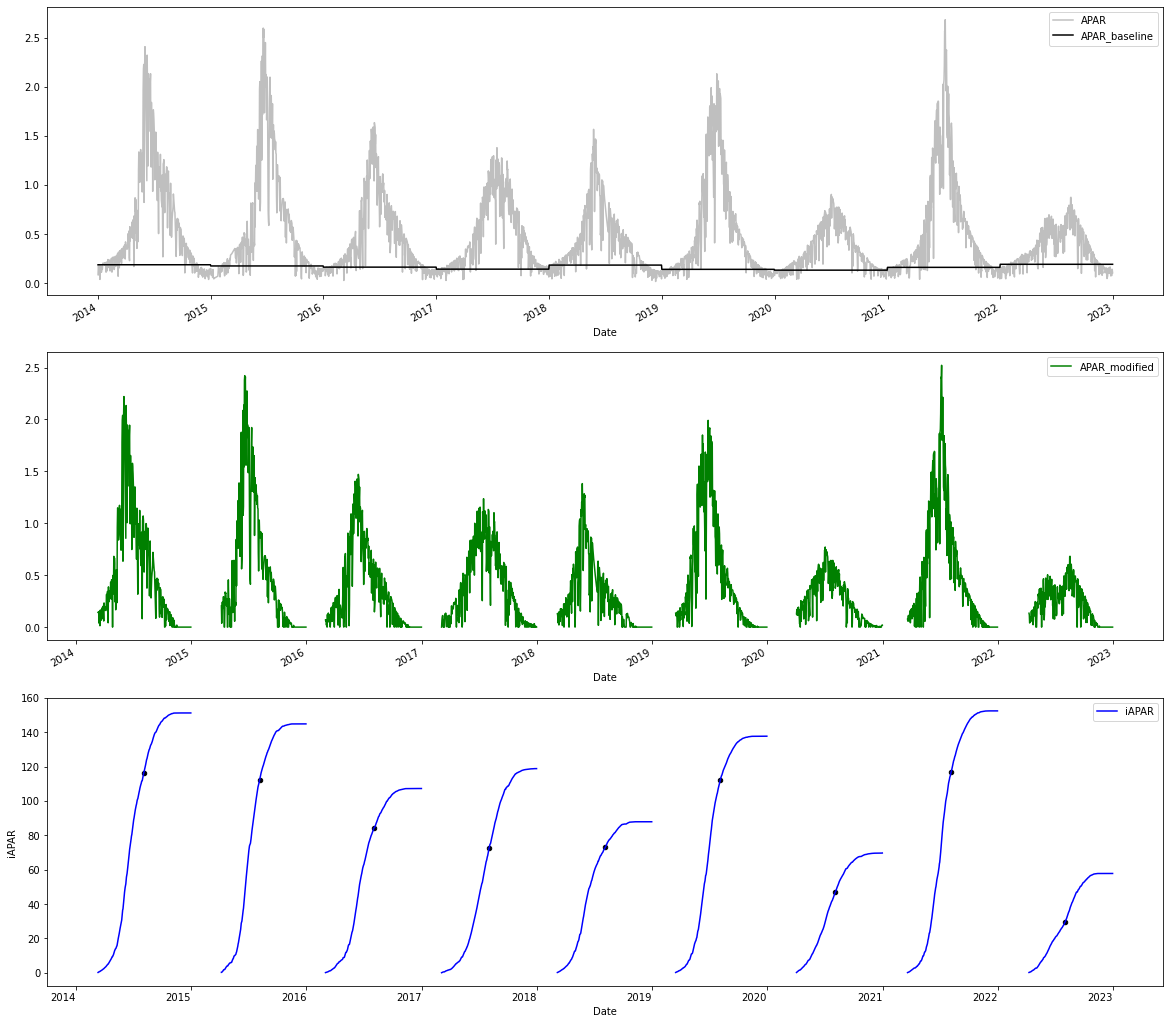

In [22]:
import seaborn as sns
fig, axs = plt.subplots(nrows=3, figsize=(20, 20))
plot = '18S_P4'
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR', ax=axs[0], c='grey', alpha=0.5)
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR_baseline', ax=axs[0], c='black')
APAR[APAR['Id'] == plot].plot(x='Date', y='APAR_modified', ax=axs[1], c='green')
APAR[APAR['Id'] == plot].plot(x='Date', y='iAPAR', ax=axs[2], c='blue')
df_merged[df_merged['Id'] == plot].plot.scatter(x='Date', y='iAPAR', s=20, c='black', ax=axs[2])
plt.show()

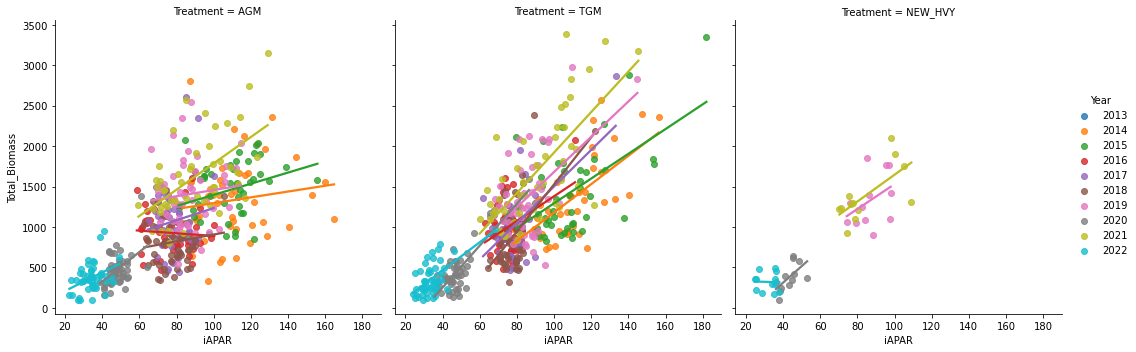

In [23]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Year', col='Treatment', ci=None, 
           data=df_merged.reset_index())
plt.show()

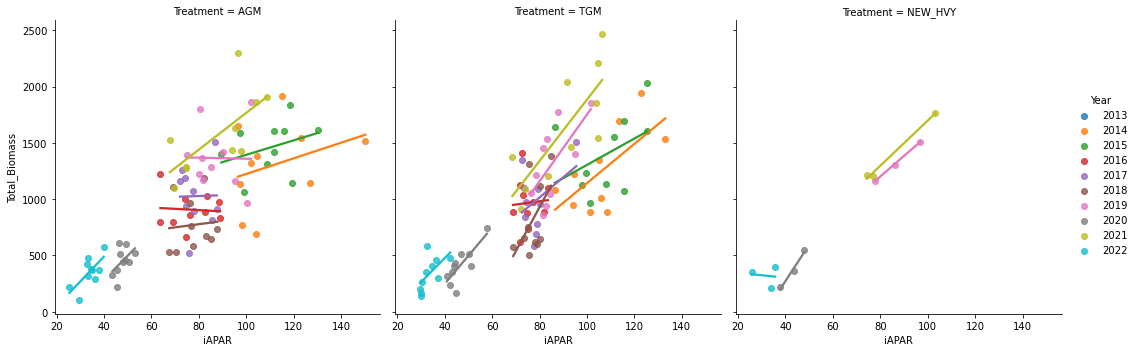

In [24]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Year', col='Treatment', ci=None, 
           data=df_merged.groupby(['Year', 'Treatment', 'Pasture']).mean(numeric_only=True).reset_index())
plt.show()

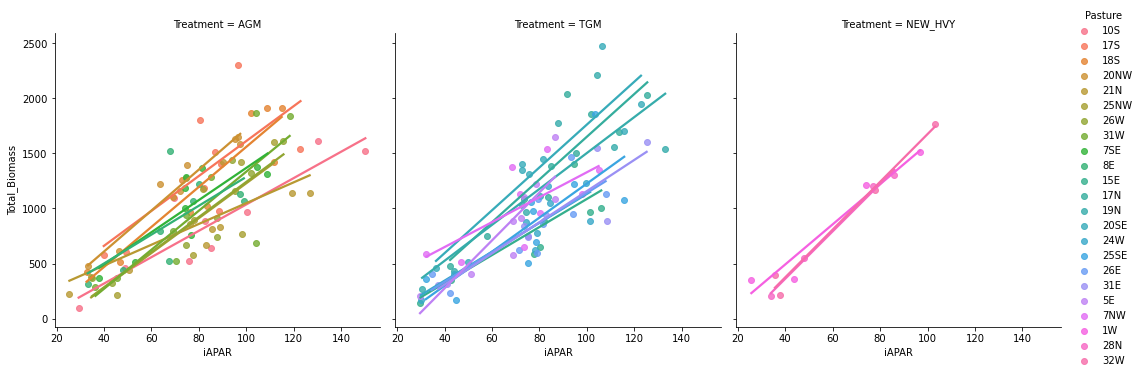

In [25]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Pasture', col='Treatment', ci=None, 
           data=df_merged.groupby(['Year', 'Treatment', 'Pasture']).mean(numeric_only=True).reset_index())
plt.show()

<Figure size 432x288 with 0 Axes>

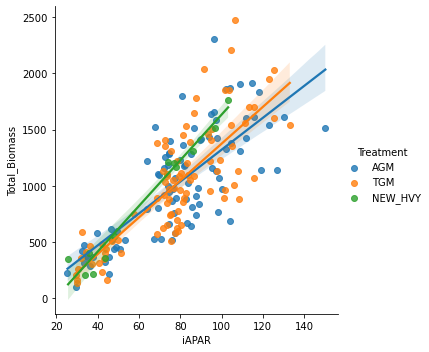

In [26]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Treatment', ci=95, 
           data=df_merged.groupby(['Year', 'Pasture', 'Treatment']).mean(numeric_only=True).reset_index())
plt.show()

In [27]:
df_merged.to_csv(outPATH, index=False)